In [34]:
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent.parent))
import librosa
import matplotlib.pyplot as plt
from tensor_hero.visualization import slice_notes
from tensor_hero.preprocessing.data import __remove_release_keys, __remove_modifiers
from tensor_hero.preprocessing.chart import chart2tensor
from tensor_hero.visualization import __create_scatter_axes, plot_chart
from tensor_hero.onset import ninos, get_10ms_onset_frames, onset_select, onset_frames_to_time
from tensor_hero.onset import onset_select, onset_frames_to_time
import mir_eval
import sounddevice as sd
import numpy as np
import math

def load_song(song_dir):
    '''Loads audio, sr, and notes array from song_dir, returns audio and notes array sliced
    into 4 second chunks

    Args:
        song_dir (Path): Path to song directory containing both notes.chart and other.wav
    
    Returns:
        notes_arrays (2D numpy array): Matrix of numpy arrays where each row is a 4 second notes array
        audio_segments (2D numpy array): Matrix of raw audio arrays where each row is 4 seconds of audio
        sr (int): sample rate
    '''
    # Get simplified notes array and audio
    notes_array = chart2tensor(song_dir / 'notes.chart')
    notes_array = __remove_modifiers(__remove_release_keys(notes_array))
    audio, sr = librosa.load(str(song_dir / 'other.wav'))
 
    # Pad audio and notes array to be divisible by 4 seconds
    audio = np.pad(audio, (0, (sr*4) - audio.shape[0]%(sr*4)), 'constant', constant_values=0)
    notes_array = np.pad(notes_array, (0, 400 - notes_array.shape[0]%400), 'constant', constant_values=0)

    # Slice into segments
    audio_segments = np.array([audio[(i*4)*sr:(i+1)*4*sr] for i in range(int(audio.shape[0]/(sr*4)))])
    notes_arrays = np.array([notes_array[i*400:(i+1)*400] for i in range(int(notes_array.shape[0]/400))])
    return audio_segments, notes_arrays, sr


def get_properties(audio, sr, p=0.05, gamma=0.94, hop_len=441, use_filtered_spec=True, _print=False):
    '''Generates several candidate odf functions from audio

    Args:
        audio (1D numpy array): Raw audio waveform, will be resampled
        sr (inr): Sample rate corresponding to audio
        p (float in (0,1), optional): Desired portion of spec to keep. Defaults to 0.05.
        gamma (float in (0,1), optional): Proportortion of spec to use for spectral sparsity. Defaults to 0.94.
        hop_len (int, optional): Hop length to use for spectrogram calculation. Defaults to 441.
            - hop_len is relative to sr = 44100, as audio is resampled to this initially
        use_filtered_spec (bool, optional): If True, spectrogram will be filtered by p. Defaults to True.
        _print (bool, optional): If True, prints shapes of odf functions. Defaults to False.

    Returns:
    return spec, mfcc, odf, energy, odf_energy, log_energy_novelty, spectral_novelty
        spec (2D numpy array): Spectrogram of audio
        mfcc (2D numpy array): 20 MFCCs of audio
        odf (1D numpy array): Spectral sparsity calculated by ninos()
        energy (1D numpy array): RMS energy of audio
        odf_energy (1D numpy array): odf*energy
        log_energy_novelty: Log energy novelty of audio (see link below)
        spectral_novelty: Spectral novelty of audio (see link below)
            - https://musicinformationretrieval.com/novelty_functions.html
    '''
    resampled = librosa.resample(audio, sr, 44100)

    # log-mel spectrogram, 10ms time bins
    spec = librosa.feature.melspectrogram(resampled, 44100, n_fft=2048*2, hop_length=hop_len, n_mels=512, power=2, fmax = sr/2)
    spec = librosa.power_to_db(spec, ref=np.max)
    if use_filtered_spec:
        spec = filter_spec_by_amplitude(spec, p=p)
    
    # mfcc, 10ms time bins
    mfcc = librosa.feature.mfcc(S=spec, n_mfcc=20)    

    # odf, 10ms time bins
    odf, _, _ = ninos(audio, sr, spec=spec, gamma=gamma)

    # energy, 10ms time bins
    energy = librosa.feature.rms(S=spec, frame_length=1022)[0]

    # odf_energy = odf*energy at each timestep
    odf_energy = np.multiply(odf, energy)
    
    # log energy novelty
    log_energy = np.log1p(10*energy)
    log_energy_diff = np.zeros_like(log_energy)
    log_energy_diff[1:] = np.diff(log_energy)
    log_energy_novelty = np.max([np.zeros_like(log_energy_diff), log_energy_diff], axis=0)

    # spectral novelty
    spectral_novelty = librosa.onset.onset_strength(S=spec)

    if _print:
        print(f'spec shape: {spec.shape}')
        print(f'mfcc shape: {mfcc.shape}')
        print(f'odf shape: {odf.shape}')
        print(f'energy shape: {energy.shape}')
        print(f'odf_energy shape: {odf_energy.shape}')
        print(f'log energy novelty shape: {log_energy_novelty.shape}')
        print(f'spectral novelty shape: {spectral_novelty.shape}')
    

    return spec, mfcc, odf, energy, odf_energy, log_energy_novelty, spectral_novelty

def filter_spec_by_amplitude(spec, p):
    '''Filters out (1-p)% of elements with the smallest values from spec

    Args:
        spec (2D numpy array): spectrogram or other 2D matrix
        p (float in [0, 1]): desired portion of spec to keep
    
    Returns:
        (2D numpy array): spec with low values filtered out
    '''
    num_elements = np.size(spec)
    num_to_keep = int(p*num_elements)
    t_val = np.flip(np.sort(spec, axis=None))[num_to_keep]  # Threshold
    spec[spec < t_val] = np.min(spec)
    return spec

def onset_frame_f1(gt, c, sr, hop_len):
    '''Takes ground truth and candidate onset frames and returns f1 score

    Args:
        gt (1D numpy array): ground truth onset frames from notes array
        c (1D numpy array): candidate onset frames
        sr (_type_): _description_
        hop_len (_type_): _description_

    Returns:
        _type_: _description_
    '''
    gt = np.array(onset_frames_to_time(gt, 44100, 441))
    c = np.array(onset_frames_to_time(c, sr=sr, hop_len=hop_len))
    f1, _, _ = mir_eval.onset.f_measure(gt, c)
    return f1

def plot_properties(spec=None, mfcc=None, ground_truth=None, odf=None, energy=None, 
                    odf_energy=None, log_energy_novelty=None, spectral_novelty=None,
                    onset_params = [2, 3, 7, 1, 3, 0.01], SHOW=True, hop_len=None, sr=None, 
                    suptitle='Properties'):
    '''TODO

    Args:
        spec (_type_, optional): _description_. Defaults to None.
        mfcc (_type_, optional): _description_. Defaults to None.
        ground_truth (_type_, optional): _description_. Defaults to None.
        odf (_type_, optional): _description_. Defaults to None.
        energy (_type_, optional): _description_. Defaults to None.
        odf_energy (_type_, optional): _description_. Defaults to None.
        log_energy_novelty (_type_, optional): _description_. Defaults to None.
        spectral_novelty (_type_, optional): _description_. Defaults to None.
        onset_params (list, optional): _description_. Defaults to [2, 3, 7, 1, 3, 0.01].
        SHOW (bool, optional): _description_. Defaults to True.
        hop_len (_type_, optional): _description_. Defaults to None.
        sr (_type_, optional): _description_. Defaults to None.
        suptitle (str, optional): _description_. Defaults to 'Properties'.

    Returns:
        _type_: _description_
    '''
    
    # Transformations and normalizations
    odf_sum_energy = odf+energy
    log_energy_novelty_mult_odf_energy = np.multiply(log_energy_novelty, odf_energy)
    d_energy = librosa.feature.delta(energy)
    d_energy_mult_energy = np.multiply(d_energy, energy)

    odf_unnormalized = -odf
    odf = -(odf - np.min(odf)) / np.max(odf - np.min(odf)) + 1

    energy = -(energy - np.min(energy)) / np.max(energy - np.min(energy)) + 1
    d_energy = -(d_energy - np.min(d_energy)) / np.max(d_energy - np.min(d_energy)) + 1
    d_energy_mult_energy = np.multiply(d_energy, energy)
    d_energy_mult_energy = (d_energy_mult_energy - np.min(d_energy_mult_energy)) \
                            / np.max(d_energy_mult_energy - np.min(d_energy_mult_energy))

    odf_sum_energy = -(odf_sum_energy - np.min(odf_sum_energy)) / np.max(odf_sum_energy - np.min(odf_sum_energy)) + 1
    odf_energy = np.multiply(odf, energy)
    odf_energy = (odf_energy - np.min(odf_energy)) / np.max(odf_energy - np.min(odf_energy))
    log_energy_novelty = (log_energy_novelty - np.min(log_energy_novelty)) / np.max(log_energy_novelty - np.min(log_energy_novelty))
    spectral_novelty = (spectral_novelty - np.min(spectral_novelty)) / np.max(spectral_novelty - np.min(spectral_novelty))
    log_energy_novelty_mult_odf_energy = (log_energy_novelty_mult_odf_energy - np.min(log_energy_novelty_mult_odf_energy)) \
                                            / np.max(log_energy_novelty_mult_odf_energy - np.min(log_energy_novelty_mult_odf_energy))
    
    # Select onsets for odf, energy, and odf_energy
    odf_onsets = onset_select(odf, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    odf_unnormalized_onsets = onset_select(odf_unnormalized, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    energy_onsets = onset_select(energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    odf_energy_onsets = onset_select(odf_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    log_energy_novelty_onsets = onset_select(log_energy_novelty, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    spectral_novelty_onsets = onset_select(spectral_novelty, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    odf_sum_energy_onsets = onset_select(odf_sum_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    log_energy_novelty_mult_odf_energy_onsets = onset_select(log_energy_novelty_mult_odf_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    d_energy_onsets = onset_select(d_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])
    d_energy_mult_energy_onsets = onset_select(d_energy_mult_energy, w1=onset_params[0], w2=onset_params[1], w3=onset_params[2],
                                w4=onset_params[3], w5=onset_params[4], delta=onset_params[5])

    # get onsets from chart, convert to same frame width as onsets described above
    gt_onsets = np.where(ground_truth>0)[0]
    expansion_factor = odf.shape[0] / ground_truth.shape[0]
    gt_onsets = [x*expansion_factor for x in gt_onsets]
    
    # Compute f1 scores of onsets, to be displayed with title
    odf_f1 = onset_frame_f1(gt_onsets, odf_onsets, sr=44100, hop_len=hop_len)
    odf_unnormalized_f1 = onset_frame_f1(gt_onsets, odf_unnormalized_onsets, sr=44100, hop_len=hop_len)
    energy_f1 = onset_frame_f1(gt_onsets, energy_onsets, sr=44100, hop_len=hop_len)
    odf_energy_f1 = onset_frame_f1(gt_onsets, odf_energy_onsets, sr=44100, hop_len=hop_len)
    log_energy_novelty_f1 = onset_frame_f1(gt_onsets, log_energy_novelty_onsets, sr=44100, hop_len=hop_len)
    spectral_novelty_f1 = onset_frame_f1(gt_onsets, spectral_novelty_onsets, sr=44100, hop_len=hop_len)
    odf_sum_energy_f1 = onset_frame_f1(gt_onsets, odf_sum_energy_onsets, sr=44100, hop_len=hop_len)
    log_energy_novelty_mult_odf_energy_f1 = onset_frame_f1(gt_onsets, odf_onsets, sr=44100, hop_len=hop_len)
    d_energy_f1 = onset_frame_f1(gt_onsets, d_energy_onsets, sr=44100, hop_len=hop_len)
    d_energy_mult_energy_f1 = onset_frame_f1(gt_onsets, d_energy_mult_energy_onsets, sr=44100, hop_len=hop_len)
    
    # Get number of gt onsets to compute saturation
    num_gt_onsets = len(gt_onsets) 

    ax_idx = 0 # Will be increased with each subsequent subplot
    
    if SHOW:
        num_subplots = int(spec is not None) + int(mfcc is not None) \
                    + int(ground_truth is not None) + int(odf is not None) \
                    + int(energy is not None) + int(odf_energy is not None) \
                    + int(log_energy_novelty is not None) + int(spectral_novelty is not None) \
                    + 5
        
        fig, axes = plt.subplots(num_subplots)
        fig.set_size_inches(25, 3*num_subplots)
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle(suptitle, y=0.93, fontsize=20)

        if spec is not None:
            axes[ax_idx].imshow(spec, aspect='auto', origin='lower')
            axes[ax_idx].set_title('spec')
            ax_idx += 1
        
        if mfcc is not None:
            axes[ax_idx].imshow(mfcc, aspect='auto', origin='lower')
            axes[ax_idx].set_title('mfcc')
            ax_idx += 1

        if ground_truth is not None:
            __create_scatter_axes(ground_truth, axes[ax_idx])
            axes[ax_idx].set_title('Ground Truth')
            ax_idx += 1
        
        if odf_unnormalized is not None:
            axes[ax_idx].plot(odf_unnormalized)
            axes[ax_idx].margins(0)
            
            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in odf_unnormalized_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'odf_unnormalized | f1 = {odf_unnormalized_f1:.2f} | saturation = {odf_unnormalized_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if odf is not None:
            axes[ax_idx].plot(odf)
            axes[ax_idx].margins(0)
            
            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in odf_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'odf | f1 = {odf_f1:.2f} | saturation = {odf_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1
        
        if energy is not None:
            axes[ax_idx].plot(energy)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('energy')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in energy_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'energy | f1 = {energy_f1:.2f} | saturation = {energy_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if d_energy is not None:
            axes[ax_idx].plot(d_energy)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('d_energy')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in d_energy_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'd_energy | f1 = {d_energy_f1:.2f} | saturation = {d_energy_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if d_energy_mult_energy is not None:
            axes[ax_idx].plot(d_energy_mult_energy)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('d_energy_mult_energy')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in d_energy_mult_energy_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'd_energy_mult_energy | f1 = {d_energy_mult_energy_f1:.2f} | saturation = {d_energy_mult_energy_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        # odf sum energy
        if odf_sum_energy is not None:
            axes[ax_idx].plot(odf_sum_energy)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('odf_sum_energy')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in odf_sum_energy_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'odf_sum_energy | f1 = {odf_sum_energy_f1:.2f} | saturation = {odf_sum_energy_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if odf_energy is not None:
            axes[ax_idx].plot(odf_energy)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('odf_energy')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in odf_energy_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'odf_energy | f1 = {odf_energy_f1:.2f} | saturation = {odf_energy_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if log_energy_novelty is not None:
            axes[ax_idx].plot(log_energy_novelty)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('log_energy_novelty')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in log_energy_novelty_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'log_energy_novelty | f1 = {log_energy_novelty_f1:.2f} | saturation = {log_energy_novelty_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if spectral_novelty is not None:
            axes[ax_idx].plot(spectral_novelty)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('spectral_novelty')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in spectral_novelty_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'spectral_novelty | f1 = {spectral_novelty_f1:.2f} | saturation = {spectral_novelty_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        if log_energy_novelty_mult_odf_energy is not None:
            axes[ax_idx].plot(log_energy_novelty_mult_odf_energy)
            axes[ax_idx].margins(0)
            axes[ax_idx].set_title('log_energy_novelty_mult_odf_energy')

            # Plot onsets
            for o in gt_onsets:
                axes[ax_idx].axvline(x=o, ymin=0, ymax=0.2, color='r')
            for o in log_energy_novelty_mult_odf_energy_onsets:
                axes[ax_idx].axvline(x=o, ymin=0.2, ymax=0.4, color='g')
            axes[ax_idx].set_title(f'log_energy_novelty_mult_odf_energy | f1 = {log_energy_novelty_mult_odf_energy_f1:.2f} | saturation = {log_energy_novelty_mult_odf_energy_onsets.shape[0]/num_gt_onsets:.2f}')

            ax_idx += 1

        fig.align_xlabels(axes)

        plt.show()
    else:
        fig = None
    
    # Construct statistics dictionaries
    onset_f1s = {
        'odf_unnormalized' : odf_unnormalized_f1,
        'odf' : odf_f1,
        'energy' : energy_f1,
        'd_energy' : d_energy_f1,
        'd_energy_mult_energy' : d_energy_mult_energy_f1,
        'odf_sum_energy' : odf_sum_energy_f1,
        'odf_energy' : odf_energy_f1,
        'log_energy_novelty' : log_energy_novelty_f1,
        'spectral_novelty' : spectral_novelty_f1,
        'log_energy_novelty_mult_odf_energy' : log_energy_novelty_mult_odf_energy_f1,
    }
    onset_saturations = {
        'odf_unnormalized' : odf_unnormalized_onsets.shape[0]/num_gt_onsets,
        'odf' : odf_onsets.shape[0]/num_gt_onsets,
        'energy' : energy_onsets.shape[0]/num_gt_onsets,
        'd_energy' : d_energy_onsets.shape[0]/num_gt_onsets,
        'd_energy_mult_energy' : d_energy_mult_energy_onsets.shape[0]/num_gt_onsets,
        'odf_sum_energy' : odf_sum_energy_onsets.shape[0]/num_gt_onsets,
        'odf_energy' : odf_energy_onsets.shape[0]/num_gt_onsets,
        'log_energy_novelty' : log_energy_novelty_onsets.shape[0]/num_gt_onsets,
        'spectral_novelty' : spectral_novelty_onsets.shape[0]/num_gt_onsets,
        'log_energy_novelty_mult_odf_energy' : log_energy_novelty_mult_odf_energy_onsets.shape[0]/num_gt_onsets,
    }
    return fig, onset_f1s, onset_saturations

def analyze_audio_onsets(audio, sr, notes_array, p=0.99, gamma=0.94, onset_params=[2, 3, 7, 1, 3, 0.01], show_plot=True, 
                         hop_len=441, suptitle='Properties', use_filtered_spec=True, print_odf_shapes=False):
    
    # Get ODF functions
    spec, mfcc, odf, energy, odf_energy, \
    log_energy_novelty, spectral_novelty = get_properties(audio, sr=sr, p=p, gamma=gamma, 
                                                          hop_len=hop_len, _print=print_odf_shapes,
                                                          use_filtered_spec=use_filtered_spec)
    
    # Plot and gather performance statistics
    fig, onset_f1s, onset_saturations = plot_properties(spec=spec, mfcc=mfcc, ground_truth=notes_array, odf=odf, 
                                                        energy=energy, odf_energy=odf_energy, 
                                                        log_energy_novelty=log_energy_novelty, spectral_novelty=spectral_novelty, 
                                                        SHOW=show_plot, hop_len=hop_len, sr=sr, suptitle=suptitle,
                                                        onset_params=onset_params)
    
    summary_statistics = {
        'onset_f1s' : onset_f1s,
        'onset_saturations' : onset_saturations,
    }
    
    return fig, summary_statistics

In [2]:
# Get a few 10 second song segments to try out (10 seconds defined below)
anberlin_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Anberlin - The Feel Good Drag'

infected_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Bad Religion - Infected'

number_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Ben Harper and Relentless7 - Number with No Name'

soothsayer_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Buckethead - Soothsayer (xX760Xx)'

misirlou_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Dick Dale - Misirlou'

littlewing_path = Path.cwd().parent.parent / 'Training_Data' / 'fully_curated' / 'full_curated' \
    / 'Jimi Hendrix - Little Wing'


In [3]:
audios, notes_arrays, sr = load_song(soothsayer_path)
print(f'{audios.shape[0]} available segments')

In [ ]:
onset_params=[2, 3, 7, 1, 3, 0.2]

fig, summary_statistics = analyze_audio_onsets(audio=audios[70], sr=sr, 
                                               notes_array=notes_arrays[70], 
                                               p=0.2,
                                               onset_params=onset_params)

In [40]:
onset_params=[2, 3, 7, 1, 3, 0.1]

full_f1s = {}
full_saturations = {}
for i in range(notes_arrays.shape[0]):
    fig, summary_statistics = analyze_audio_onsets(audio=audios[i], sr=sr, 
                                                notes_array=notes_arrays[i], 
                                                p=0.2,
                                                onset_params=onset_params,
                                                show_plot=False)
    # Create skeleton for full statistics
    if not full_f1s and not full_saturations:
        for k in summary_statistics['onset_f1s'].keys():
            full_f1s[k] = []
            full_saturations[k] = []
   
    # Populate full statistics through time
    for k, v in summary_statistics['onset_f1s'].items():
        full_f1s[k].append(v)
    for k, v in summary_statistics['onset_saturations'].items():
        full_saturations[k].append(v)

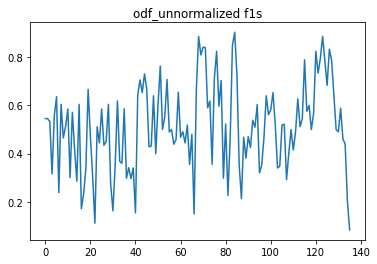

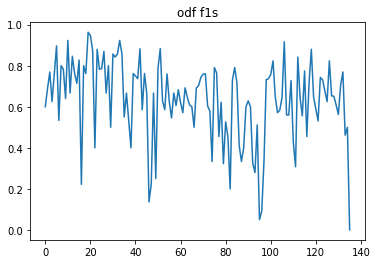

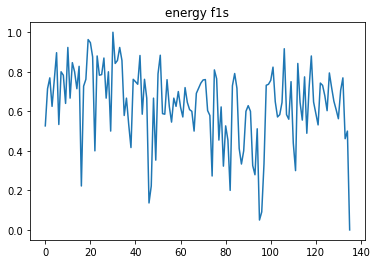

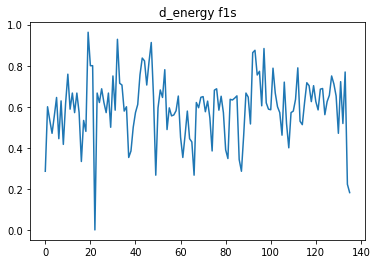

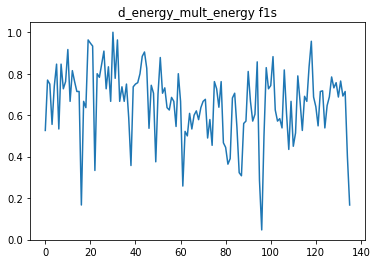

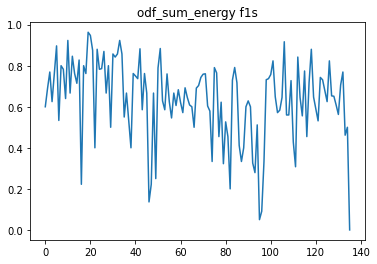

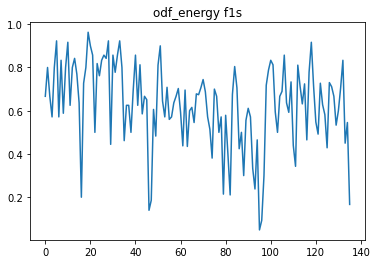

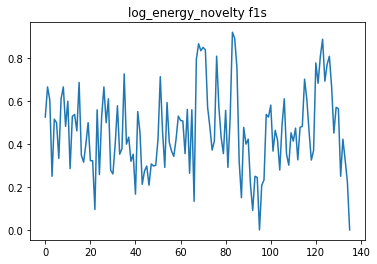

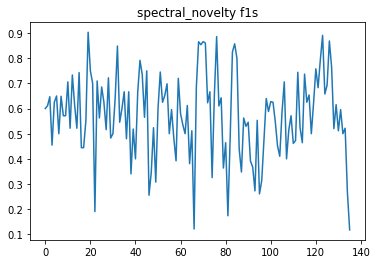

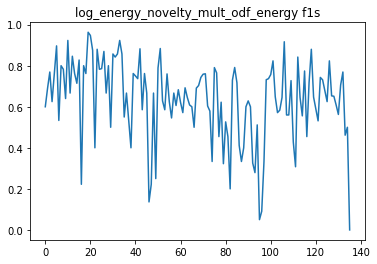

In [42]:
for odf, vals in full_f1s.items():
    plt.figure()
    plt.plot(vals)
    plt.title(f'{odf} f1s')

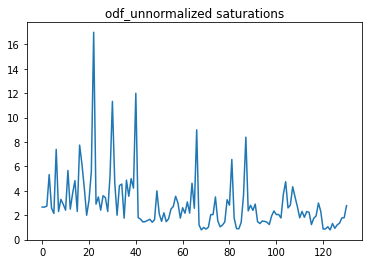

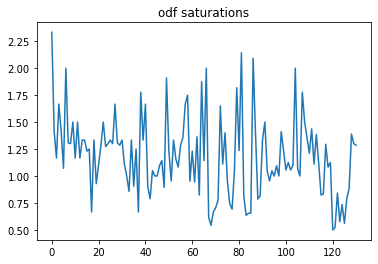

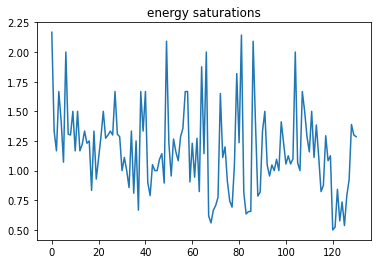

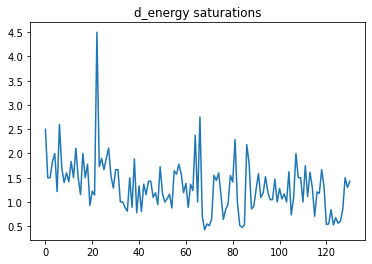

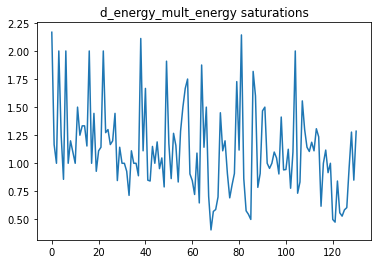

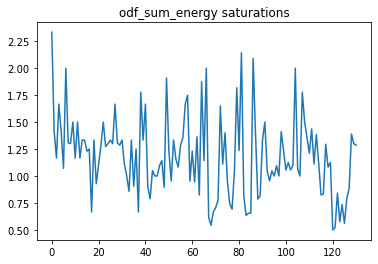

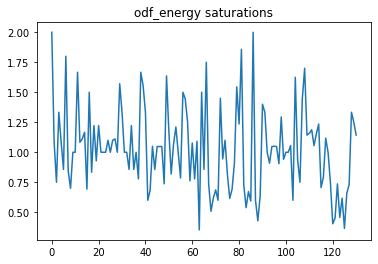

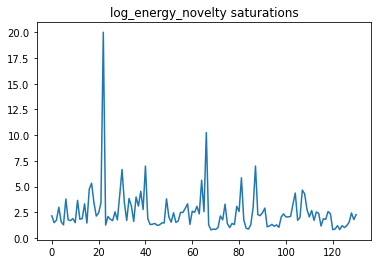

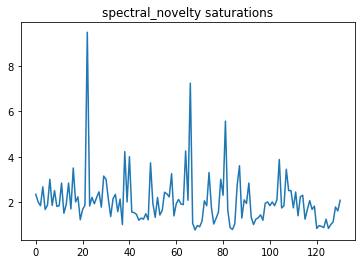

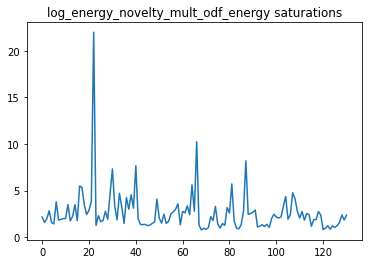

In [45]:
for odf, vals in full_saturations.items():
    plt.figure()
    plt.plot(vals[:-5])
    plt.title(f'{odf} saturations')